In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from collections import defaultdict

In [2]:
from source.tokeniser import load_tokeniser_from_rsmiles
print("Building tokeniser...")
tokeniser = load_tokeniser_from_rsmiles("data/USPTO_50K_PtoR_aug20")
print(f"Finished tokeniser with {len(tokeniser)} tokens.")

Building tokeniser...
Chemistry tokens start at index 6
Finished tokeniser with 74 tokens.


In [3]:
chains = np.load('ForwardDiffusionEval_sample_chains.npy')
print(chains.shape)
T = chains.shape[1]

(10, 2000, 64)


In [4]:
true_smiles, sample_chains = chains[:, 0], chains[:, 1:]
true_smiles = true_smiles.flatten()
sample_chains = sample_chains.transpose(1, 0, 2).reshape((T-1, -1))

In [5]:
tokens = tokeniser.tokenise(true_smiles[:10])['original_tokens']
print(tokens)

token_ids = tokeniser.convert_tokens_to_ids(tokens)
print(token_ids)

print(tokeniser.tokenise(['<MASK><PAD><SEP>']))

[['^', 'C', '1', '[C@@H]', '(', 'C', '(', 'N', '[C@@H]', '(', 'C', 'C', 'C', ')', 'C', '(', '=', 'O', ')', 'O', ')', '=', 'O', ')', '[C@H]', '(', 'C', '(', '=', 'O', ')', 'N', '[C@@H]', '(', 'C', '(', 'C', ')', 'C', ')', 'C', '(', 'N', '[C@H]', '(', 'C', '(', 'O', 'C', ')', '=', 'O', ')', 'C', '2', 'C', 'C', 'C', 'C', 'C', '2', ')', '=', 'O', ')', 'C', '[C@@H]', '1', 'O', 'c', '1', 'c', '2', 'c', '(', 'n', 'c', '(', '-', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', ')', 'c', '1', ')', 'c', 'c', '(', 'O', 'C', ')', 'c', 'c', '2', '&'], ['^', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', '1', 'n', 'c', '(', 'C', ')', 'n', '2', 'C', 'C', 'n', '1', 'c', 'c', '(', 'N', ')', 'c', 'n', '1', '&'], ['^', 'n', '1', '(', '-', 'c', '2', 'c', '(', 'N', ')', 'c', 'c', '(', 'F', ')', 'c', 'c', '2', ')', 'c', '(', 'C', 'C', 'C', '(', '=', 'O', ')', 'O', 'C', 'C', ')', 'n', 'c', 'c', '1', '&'], ['^', 'N', 'C', '(', '=', 'O', ')', 'c', '1', 'c', '(', 'N', 'c', '2', 'c', 'c', 'c', '(', 'N', '3', 'C', 'C', 'N', '(',

In [6]:
frequencies = []
for t in range(0, len(sample_chains), 1):    
    frequency_dict = defaultdict(int)
    tokens = tokeniser.tokenise(sample_chains[t])['original_tokens']
    for sample in tokens:
        for ch in sample:
            frequency_dict[ch] += 1
    # frequency_dict.pop('?')
    frequencies.append((t, frequency_dict))

In [7]:
true_frequencies = defaultdict(int)
for sample in tokeniser.tokenise(true_smiles)['original_tokens']:
    for ch in sample:
        true_frequencies[ch] += 1

In [8]:
last_frequencies = frequencies[-1][-1]
true_totals, last_totals = sum(true_frequencies.values()), sum(last_frequencies.values())
for ch in sorted(last_frequencies, key=lambda x: max(true_frequencies[x], last_frequencies[x]), reverse=True):
    print(f'{ch.rjust(6)}: {true_frequencies[ch]/true_totals:.4f} vs. {last_frequencies[ch]/last_totals:.4f}')    

     c: 0.2396 vs. 0.2396
     C: 0.1594 vs. 0.1602
     ): 0.1218 vs. 0.1224
     (: 0.1218 vs. 0.1220
     O: 0.0558 vs. 0.0554
     1: 0.0544 vs. 0.0557
     2: 0.0431 vs. 0.0432
     =: 0.0324 vs. 0.0321
     N: 0.0292 vs. 0.0297
     n: 0.0231 vs. 0.0231
     ^: 0.0212 vs. 0.0212
     &: 0.0212 vs. 0.0212
     3: 0.0200 vs. 0.0191
     F: 0.0122 vs. 0.0122
     -: 0.0068 vs. 0.0069
     4: 0.0064 vs. 0.0063
    Cl: 0.0056 vs. 0.0055
     S: 0.0041 vs. 0.0040
 [C@H]: 0.0034 vs. 0.0031
[C@@H]: 0.0028 vs. 0.0028
     5: 0.0021 vs. 0.0013
    Br: 0.0020 vs. 0.0019
     s: 0.0019 vs. 0.0018
     #: 0.0017 vs. 0.0018
  [nH]: 0.0015 vs. 0.0015
  [N+]: 0.0014 vs. 0.0014
  [O-]: 0.0013 vs. 0.0013
     o: 0.0012 vs. 0.0012
     /: 0.0005 vs. 0.0006
     6: 0.0005 vs. 0.0002
     I: 0.0003 vs. 0.0003
  [Si]: 0.0003 vs. 0.0003
 [C@@]: 0.0003 vs. 0.0002
  [C@]: 0.0003 vs. 0.0003
     P: 0.0001 vs. 0.0001
  [N-]: 0.0001 vs. 0.0001
     B: 0.0001 vs. 0.0001
  [Sn]: 0.0001 vs. 0.0001
     \: 0.00

In [9]:
freq_differences = []
for ch in sorted(last_frequencies, key=lambda x: true_frequencies[x], reverse=True):
    true_freq = true_frequencies[ch]/true_totals
    sample_freq = last_frequencies[ch]/last_totals
    freq_differences.append(true_freq - sample_freq)

freq_differences = np.abs(np.array(freq_differences))
print(f"Mean: {freq_differences.mean()}")
print(f" Std: {freq_differences.std()}")
print(f" Max: {freq_differences.max()}")
print(f" Min: {freq_differences.min()}")

Mean: 0.00018391523165425775
 Std: 0.00029706827173116344
 Max: 0.0013592361755735347
 Min: 0.0


In [10]:
t, freq_maps = zip(*frequencies)

#collapse freq_maps
plotable_freqs = defaultdict(lambda: np.zeros(len(freq_maps)))
for i, fmap in enumerate(freq_maps):
    for ch, count in fmap.items():
        plotable_freqs[ch][i] = count

plotable_freqs = dict(plotable_freqs)

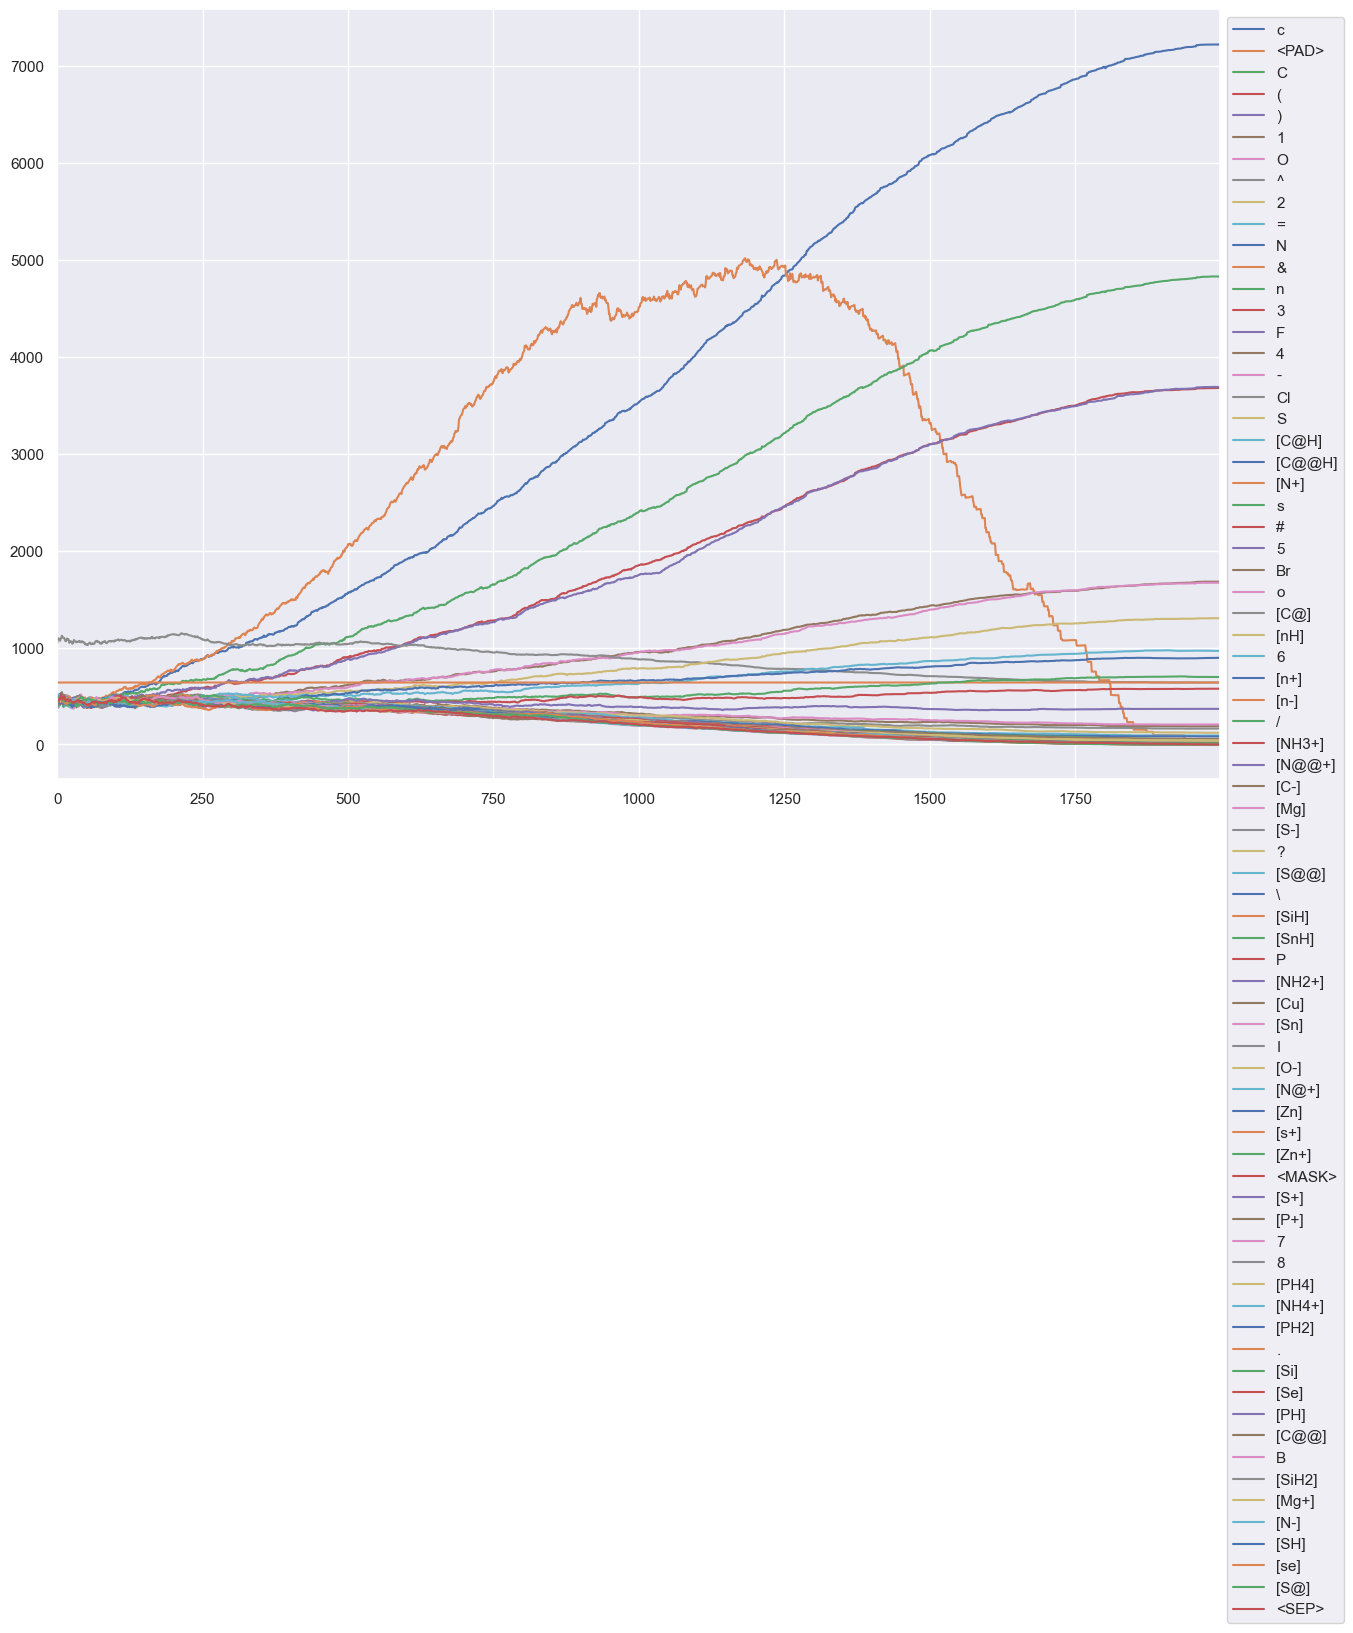

In [11]:
plt.figure(figsize=(15, 10))
for ch, counts in sorted(plotable_freqs.items(), key=lambda x: plotable_freqs[x[0]].sum(), reverse=True):
    plt.plot(t, counts, label=ch)

plt.xlim(0, T-1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()

In [12]:
from rdkit import Chem, RDLogger
RDLogger.DisableLog("rdApp.*")

In [13]:
sampled_smiles = sample_chains[-1]
sampled_smiles = [s.rstrip('?') for s in sampled_smiles]

mol_targets = [Chem.MolFromSmiles(smi) for smi in true_smiles]
canon_targets = [Chem.MolToSmiles(mol) for mol in mol_targets]

sampled_mols = [Chem.MolFromSmiles(smi) for smi in sampled_smiles]
invalid = [mol is None for mol in sampled_mols]

canon_smiles = ["Unknown" if mol is None else Chem.MolToSmiles(mol) for mol in sampled_mols]
correct_smiles = [canon_targets[idx] == smi for idx, smi in enumerate(canon_smiles)]

num_correct = sum(correct_smiles)
total = len(correct_smiles)
num_invalid = sum(invalid)
perc_invalid = num_invalid / total
accuracy = num_correct / total

print(perc_invalid)
print(accuracy)
print(num_correct / (total - num_invalid))

0.5015625
0.353125
0.7084639498432602


In [14]:
for i, (true_smi, sample_smi) in enumerate(zip(true_smiles, sampled_smiles)):
    if i > 10:
        break
    
    print(f'  True: {true_smi}')
    print(f'Sample: {sample_smi} ({"invalid" if invalid[i] else "valid"}, {"correct" if correct_smiles[i] else "incorrect"})')

  True: C1[C@@H](C(N[C@@H](CCC)C(=O)O)=O)[C@H](C(=O)N[C@@H](C(C)C)C(N[C@H](C(OC)=O)C2CCCCC2)=O)C[C@@H]1Oc1c2c(nc(-c3ccccc3)c1)cc(OC)cc2
Sample: c1(-c2cc(O[C@H]3C[C@@H](CCC)=OCCC)NC(=O)N[C@@H](C(N[C@@H](C(C)C)C(=O)N[C@H](C(OC)=O)C4CC4)C(C)C)Cc4cc(OC)ccc43)c2)c)ccccc1 (invalid, incorrect)
  True: c1cccc2c1nc(C)n2CCn1cc(N)cn1
Sample: c1c(N)cnn1CCn1c(C)nc2c1cccc2 (valid, correct)
  True: n1(-c2c(N)cc(F)cc2)c(CCC(=O)OCC)ncc1
Sample: C(CCc1n(-c2c(N)cc(F)cc2)ccn1)(OCC)=O (valid, correct)
  True: NC(=O)c1c(Nc2ccc(N3CCN(C)CC3)c(-c3ccncc3)c2)nc(Oc2cc([N+]([O-])=O)ccc2)cn1
Sample: c1c(Oc2nc(Nc3ccc(N4CCN(C)CC4)cc4ccncc4)c3)cc3)c(C(=O)N)cc2)cc1[N+]([O-])=O (invalid, incorrect)
  True: c1cc(F)cc2c1[nH]c(C1CCN(C(=O)OC(C)(C)C)CC1)n2
Sample: c1(F)cccc2c1[nH]c(C1CCN(C(=O)OC(C)(C)C)CC1)n2 (valid, incorrect)
  True: Oc1ccc2c(c1COCC(C)C)CCCC2=O
Sample: CC(COCc1c2ccc1O)C(=O)CCC2)C (invalid, incorrect)
  True: C(CC(O)=O)Cc1cc(C)c(OC)cc1
Sample: C(C(O)(=O)CCc1cc(C)c(OC)c1 (invalid, incorrect)
  True: c12c(c(O

In [15]:
valid_len, invalid_len = [], []
for inval, sample in zip(invalid, tokeniser.tokenise(sampled_smiles)['original_tokens']):
    if inval:
        invalid_len.append(len(sample))
    else:
        valid_len.append(len(sample))

print(np.mean(valid_len), np.std(valid_len))
print(np.mean(invalid_len), np.std(invalid_len))

38.07210031347962 13.332655092926082
56.13395638629284 15.621620120465387


In [16]:
correct_len, incorrect_len = [], []
for inval, correct, sample in zip(invalid, correct_smiles, tokeniser.tokenise(sampled_smiles)['original_tokens']):
    if not inval:
        if correct:
            correct_len.append(len(sample))
        else:
            incorrect_len.append(len(sample))

print(np.mean(correct_len), np.std(correct_len))
print(np.mean(incorrect_len), np.std(incorrect_len))

35.80530973451327 11.61998462146915
43.58064516129032 15.452544475475959


In [17]:
len_diffs = []
for true_smile, sample_smile in zip(tokeniser.tokenise(true_smiles)['original_tokens'],
                                    tokeniser.tokenise(sampled_smiles)['original_tokens']):
    len_diffs.append(len(true_smile) - len(sample_smile))
    
len_diffs = np.array(len_diffs)
print(f"Mean: {len_diffs.mean()}")
print(f" Std: {len_diffs.std()}")
print(f" Max: {len_diffs.max()}")
print(f" Min: {len_diffs.min()}")

Mean: 0.0
 Std: 0.0
 Max: 0
 Min: 0


In [18]:
parenteses_match = 0
ring_match = 0
left_v_right = 0
for i, sample_smi in enumerate(sampled_smiles):
    if invalid[i]:
        left_count = sample_smi.count('(')
        right_count = sample_smi.count(')')
        if left_count == right_count:
            parenteses_match += 1
        else:
            left_v_right += (right_count - left_count)

print(parenteses_match / num_invalid)
print(left_v_right / (num_invalid - parenteses_match))

0.3644859813084112
0.049019607843137254


In [ ]:
ring_match = 0
for i, sample_smi in enumerate(sampled_smiles):
    if invalid[i]:
        for i in range(1, 10):
            count = sample_smi.count(str(i))
            if count % 2:
                break
        else:
            ring_match += 1
        
print(ring_match / num_invalid)

In [29]:
aromatic_error = 0
for i, sample_smi in enumerate(sampled_smiles):
    if invalid[i]:
        ring_err = False
        for i in range(1, 10):
            count = sample_smi.count(str(i))
            if count % 2:
                ring_err = True
                break

        left_count = sample_smi.count('(')
        right_count = sample_smi.count(')')
        if left_count == right_count and not ring_err:
            aromatic_error += 1
        
print(aromatic_error / num_invalid)

0.14953271028037382


In [30]:
from difflib import SequenceMatcher

similarities = []
for true_smi, chain in zip(true_smiles, sample_chains.transpose()):
    sims = []
    for smi in chain:
        sims.append(SequenceMatcher(None, true_smi, smi).ratio())
    similarities.append(sims)

similarities = np.array(similarities).transpose()

plt.plot(similarities.mean(axis=1))
plt.title('Average String Similarity vs. Diffusion Iteration')
plt.show()

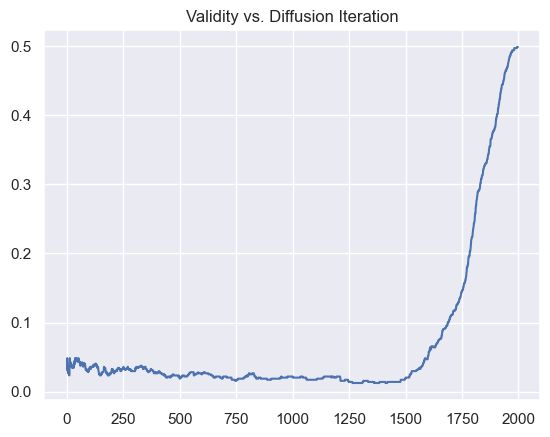

In [ ]:
validity = []
for chain in sample_chains.transpose():
    vals = []
    for smi in chain:
        smi = smi.rstrip('?')
        if Chem.MolFromSmiles(smi) is not None:
            vals.append(1)
        else:
            vals.append(0)
    validity.append(vals)

validity = np.array(validity).transpose()

plt.plot(validity.mean(axis=1))
plt.title('Validity vs. Diffusion Iteration')
plt.show()

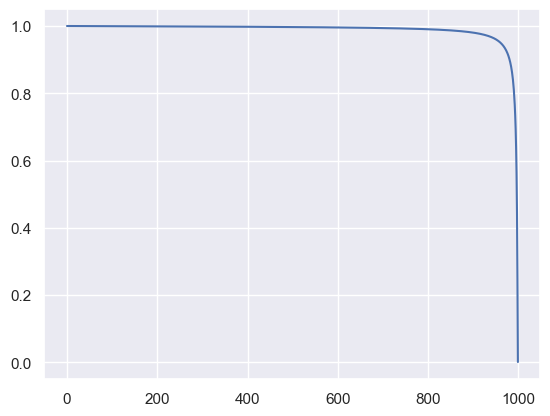

In [ ]:
# Beta schedules
from source.diff_util import cosine_beta_schedule, get_named_beta_schedule, log_1_min_a

num_timesteps = 1000
alphas = cosine_beta_schedule(num_timesteps)
alphas = 1 - get_named_beta_schedule('cosine', num_timesteps)

plt.plot(alphas)
plt.show()

Text(0.5, 1.0, 'log_1_min_cumprod_alpha')

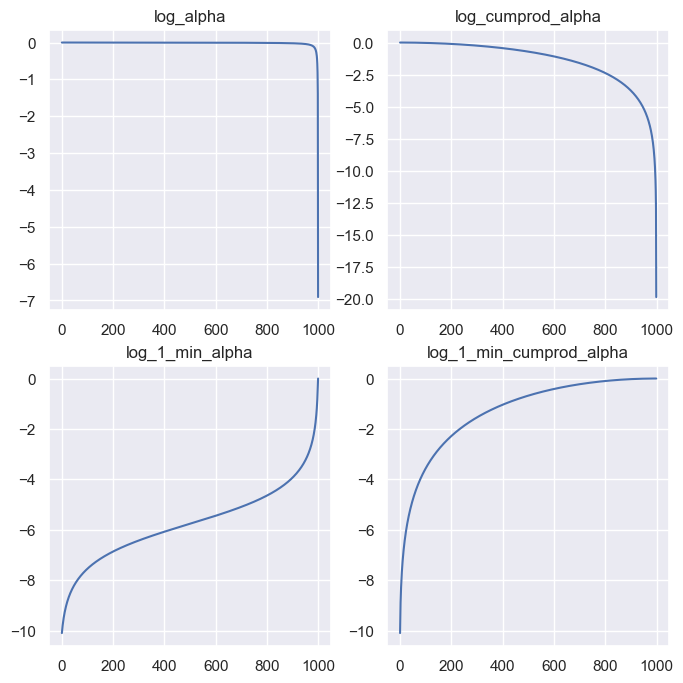

In [ ]:
import torch
alphas = torch.tensor(alphas)

log_alpha = np.log(alphas)
log_cumprod_alpha = np.cumsum(log_alpha)
log_1_min_alpha = log_1_min_a(log_alpha)
log_1_min_cumprod_alpha = log_1_min_a(log_cumprod_alpha)

fig, axes = plt.subplots(2, 2, figsize=(8,8))

axes[0,0].plot(log_alpha)
axes[0,0].set_title('log_alpha')

axes[0,1].plot(log_cumprod_alpha)
axes[0,1].set_title('log_cumprod_alpha')

axes[1,0].plot(log_1_min_alpha)
axes[1,0].set_title('log_1_min_alpha')

axes[1,1].plot(log_1_min_cumprod_alpha)
axes[1,1].set_title('log_1_min_cumprod_alpha')

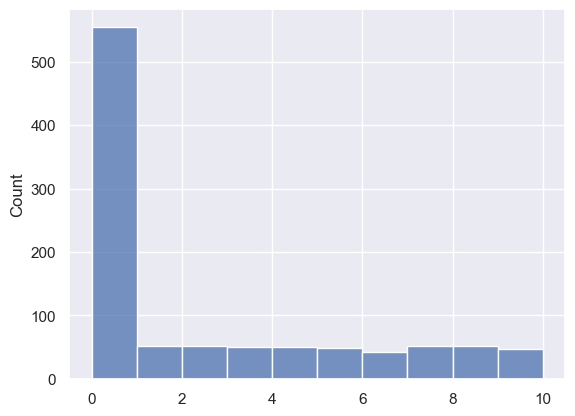

In [ ]:
num_classes = 10
t = 500

x_start = np.zeros(num_classes)
x_start[0] += 1
log_x_start = np.log(x_start.clip(min=1e-30))

def log_add_exp(a, b):
    maximum = a.copy()
    maximum[a < b] = b
    return maximum + np.log(np.exp(a - maximum) + np.exp(b - maximum))

log_cumprod_alpha_t = log_cumprod_alpha[t].numpy()
log_1_min_cumprod_alpha_t = log_1_min_cumprod_alpha[t].numpy()

log_probs = log_add_exp(
    log_x_start + log_cumprod_alpha_t,
    log_1_min_cumprod_alpha_t - np.log(num_classes)
)

logits = log_probs

data = []
for i in range(1000):
    uniform = np.random.rand(*logits.shape)
    gumbel_noise = -np.log(-np.log(uniform + 1e-30) + 1e-30)
    sample = (gumbel_noise + logits).argmax(axis=-1)
    data.append(sample)

data = np.array(data)
sns.histplot(data,bins=np.arange(data.min(), data.max()+2),kde=False)
plt.show()

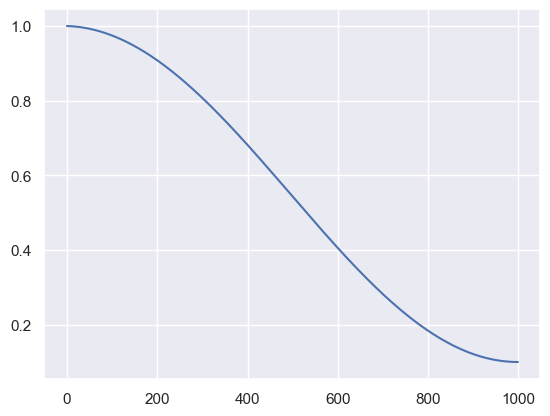

In [ ]:
data = []
for t in range(0, 1000):
    x_start = np.zeros(num_classes)
    x_start[0] += 1
    log_x_start = np.log(x_start.clip(min=1e-30))

    log_cumprod_alpha_t = log_cumprod_alpha[t].numpy()
    log_1_min_cumprod_alpha_t = log_1_min_cumprod_alpha[t].numpy()
    
    log_probs = log_add_exp(
        log_x_start + log_cumprod_alpha_t,
        log_1_min_cumprod_alpha_t - np.log(num_classes)
    )

    data.append(log_probs[0])

data = np.array(data)
plt.plot(np.exp(data))
plt.show()

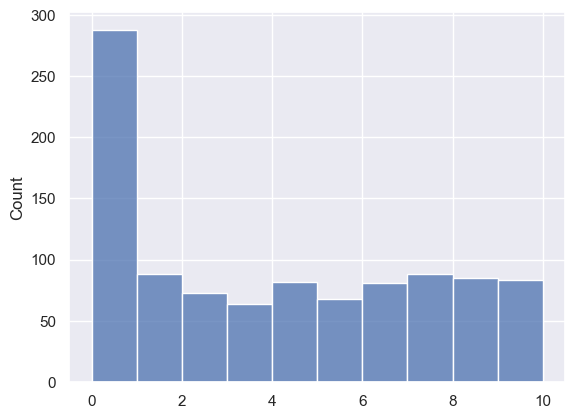

In [ ]:
num_classes = 10
t = 800

x_start = np.zeros(num_classes)
x_start[0] += 1
log_x_start = np.log(x_start.clip(min=1e-30))

def log_add_exp(a, b):
    maximum = a.copy()
    maximum[a < b] = b
    return maximum + np.log(np.exp(a - maximum) + np.exp(b - maximum))

log_cumprod_alpha_t = log_cumprod_alpha[t].numpy()
log_1_min_cumprod_alpha_t = log_1_min_cumprod_alpha[t].numpy()

log_probs = log_add_exp(
    log_x_start + log_cumprod_alpha_t,
    log_1_min_cumprod_alpha_t - np.log(num_classes)
)

logits = log_probs

data = []
for i in range(1000):
    dist = np.random.dirichlet(np.ones_like(logits))
    sample = (dist * np.exp(logits))
    sample /= sample.sum(axis = -1)
    sample = np.log(sample)
    sample = sample.argmax(axis=-1)
    # print(sample)
    data.append(sample)

data = np.array(data)
sns.histplot(data,bins=np.arange(data.min(), data.max()+2),kde=False)
plt.show()

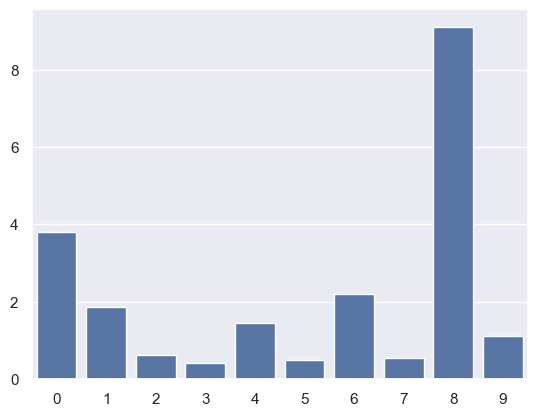

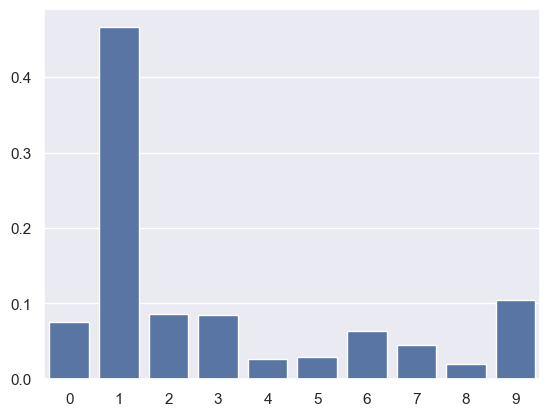

In [ ]:
uniform = np.random.rand(10)
gumbel_noise = -np.log(-np.log(uniform + 1e-30) + 1e-30)
    
sns.barplot(np.exp(gumbel_noise))
plt.show()

dirichlet = np.random.dirichlet(np.ones(10))
    
sns.barplot(dirichlet)
plt.show()

In [ ]:
import torch

dist = torch.distributions.Dirichlet(torch.ones((2, 2))).sample()
print(dist)

tensor([[0.1859, 0.8141],
        [0.3953, 0.6047]])
